In [58]:
import numpy as np
import pandas as pd

import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

Датасет представляет собой данные А/В теста для  лендинга.
- Контрольная группа (control) видела старый дизайн страницы
- Экспериментальная группв (treatment) видела новый дизайн страницы

Предполагалось, что изменение дизайна страницы приведет к увеличению конверсии в целевые действия

# Этап 0. Выгрузка и предобработка данных

In [59]:
df = pd.read_csv('ab_data.csv')
df.sample(5)

,user_id,timestamp,group,landing_page,converted
206112,921070,2017-01-06 06:55:57.072168,treatment,new_page,0
148499,887340,2017-01-18 14:40:28.443520,treatment,new_page,0
111213,890323,2017-01-13 08:14:02.315588,treatment,new_page,0
252970,861296,2017-01-14 12:26:10.049703,treatment,new_page,1
83928,796910,2017-01-20 00:02:05.406379,treatment,new_page,0


In [60]:
df.shape

(294478, 5)

In [61]:
df.duplicated().sum()

np.int64(0)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [63]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [64]:
df.isna().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


In [65]:
df.nunique()

,0
user_id,290584
timestamp,294478
group,2
landing_page,2
converted,2


**user_id** могут повторяться, так как пользователь мог переходитб на страницу не один раз. Дубликатов в **timestamp** нет, что подтверждает данное утверждение

In [66]:
df.columns.to_list()

['user_id', 'timestamp', 'group', 'landing_page', 'converted']

In [67]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Нужно очистить данные - пользователи контрольной группы должны видеть только старую страницу, а пользователи экспериментальной группы - только новую. Также нужно проверить, нет ли пользователей, кто попал в обе группы

In [68]:
# Оставляем пользователей с правильным распределением
df = df.query('group == "control" & landing_page == "old_page" | group == "treatment" & landing_page == "new_page"')
df.shape

(290585, 5)

In [69]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


In [70]:
cross_group = pd.crosstab(df['user_id'], df['group'])
cross_group.query('control == treatment')

group,control,treatment
user_id,,


Теперь нет пользователей, которые видят неправильную страницу. Также проверено, что нет пользователей случайно попавших в обе группы

# Этап 1. Анализ конверсии

In [71]:
columns = {'count': 'users_count',
           'sum': 'actions_count'}

df_summary = df.groupby('group')['converted'].agg({'sum', 'count'}).reset_index()
df_summary['conversion_rate'] = df_summary['sum']/df_summary['count']
df_summary.set_index('group', inplace=True)
df_summary = df_summary.rename(columns=columns)

df_summary


,users_count,actions_count,conversion_rate
group,,,
control,145274,17489,0.120386
treatment,145311,17264,0.118807


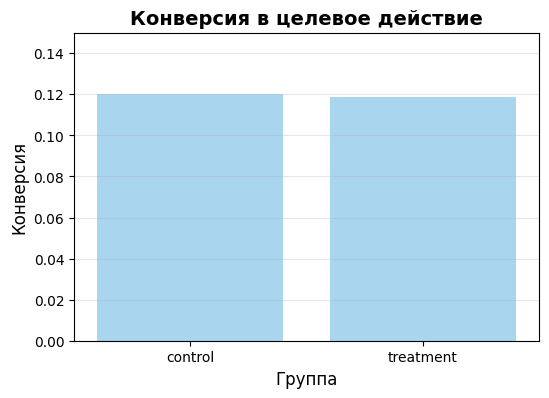

In [72]:

plt.figure(figsize=(6, 4))
sns.barplot(data=df_summary, x='group', y='conversion_rate', color='#87CEFA',alpha=0.8)

plt.ylim(0, 0.15)
plt.xlabel('Группа', fontsize=12)
plt.ylabel('Конверсия', fontsize=12)
plt.title('Конверсия в целевое действие', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

Заметим, что у экспериментальной группы число целевых действий ниже, чем у контрольной. Это ндао учесть при дальнейшей проверкезначимости различий

In [73]:
control = df.query('group == "control"').reset_index()
treatment = df.query('group == "treatment"').reset_index()

In [74]:
cont_transactions = control[control['converted'] == 1]
treat_transactions = treatment[treatment['converted'] == 1]


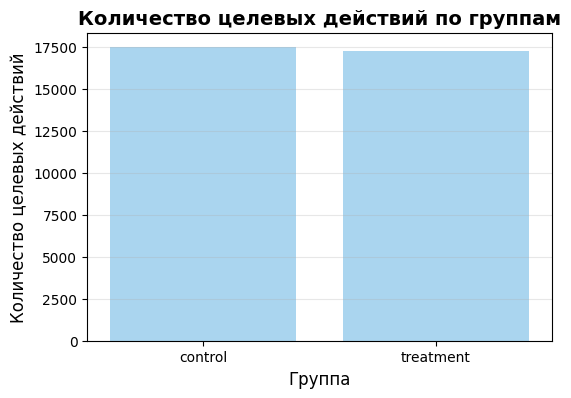

In [75]:
plot_data = pd.DataFrame({
    'group': ['control', 'treatment'],
    'transactions': [len(cont_transactions), len(treat_transactions)]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=plot_data, x='group', y='transactions', color='#87CEFA', alpha=0.8)

plt.xlabel('Группа', fontsize=12)
plt.ylabel('Количество целевых действий', fontsize=12)
plt.title('Количество целевых действий по группам', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

На первый взгляд кажется, что никаких изменений нет. Группы примерно одного размера, число целевых действий также примерно одинаково

# Этап 2. Проверка наличия различий

- Конверсия является бинарной метрикой (0 или 1)
- Выборки независимы (пользователи не пересекаются между группами)
- Размер выборок достаточен (n > 30)
- Наблюдения внутри групп независимы

Поэтому был выбран **Z-тест**.

**Нулевая гипотеза:** число кликов после введения нового дизайна страницы не изменилось

**Альтернативная гипотеза:** число кликов после введения нового дизайна стало меньше

In [76]:
alpha = 0.05

In [77]:
from statsmodels.stats.proportion import proportions_ztest

sample1 = control['converted']
sample2 = treatment['converted']

count = np.array([sample1.sum(), sample2.sum()])
nobs = np.array([len(sample1), len(sample2)])

z_stat, p_value = proportions_ztest(count, nobs)
print("Z-статистика:", z_stat)
print("P-значение:", p_value)

if p_value < alpha:
    print("Различие статистически значимо")
else:
    print("Недостаточно оснований отвергнуть нулевую гипотезу")

Z-статистика: 1.3116075339133115
P-значение: 0.18965258971881804
Недостаточно оснований отвергнуть нулевую гипотезу


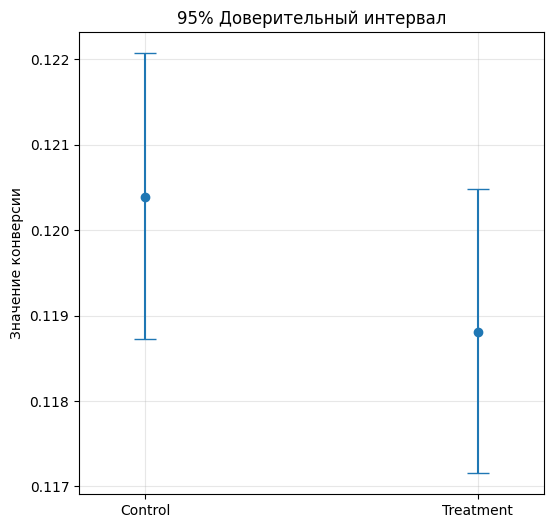

In [78]:
from statsmodels.stats.proportion import proportion_confint

successes = np.array([sample1.sum(), sample2.sum()])
totals = np.array([len(sample1), len(sample2)])

proportions = successes/totals

ci_low, ci_high = proportion_confint(
    count=successes,
    nobs=totals,
    alpha=0.05,
    method='wilson'
)

x = np.arange(len(proportions))

plt.figure(figsize=(6, 6))
plt.errorbar(
    x,
    proportions,
    yerr=[proportions - ci_low, ci_high - proportions],
    fmt='o',
    capsize=8
)
plt.margins(x=0.2)
plt.xticks(x, ['Control', 'Treatment'])
plt.ylabel('Значение конверсии')
plt.title('95% Доверительный интервал')
plt.grid(True, alpha=0.3)
plt.show()

In [79]:
lift = (0.1188 - 0.1204)/0.1204 * 100
print(f"Относительное изменение конверсии с новым дизайном: {lift:.2f}%")

Относительное изменение конверсии с новым дизайном: -1.33%


# Этап 3. Дополнительное.
Проверим, отличается ли конверсия по дням недели

In [80]:
df['weekday'] = df['timestamp'].dt.day_name()

In [81]:
columns = {'count': 'users_count',
           'sum': 'actions_count'}

df_days = df.groupby('weekday')['converted'].agg({'sum', 'count'}).reset_index()
df_days['conversion_rate'] = df_days['sum']/df_days['count']
df_days = df_days.rename(columns=columns)

df_days


,weekday,users_count,actions_count,conversion_rate
0,Friday,39626,4624,0.116691
1,Monday,45440,5505,0.121149
2,Saturday,39670,4793,0.120822
3,Sunday,39915,4729,0.118477
4,Thursday,39221,4705,0.119961
5,Tuesday,47148,5636,0.119538
6,Wednesday,39565,4761,0.120334


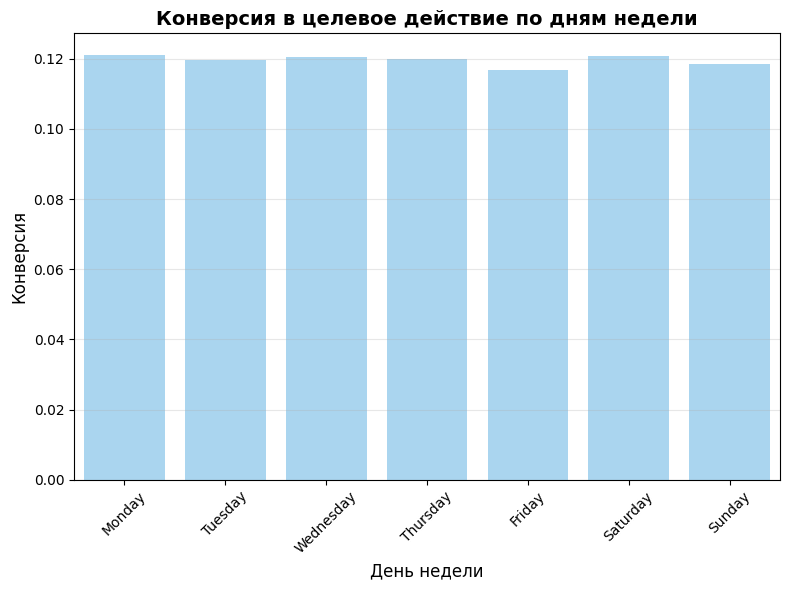

In [82]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_days['weekday'] = pd.Categorical(df_days['weekday'], categories=day_order, ordered=True)

df_days_sorted = df_days.sort_values('weekday')

plt.figure(figsize=(8, 6))
sns.barplot(data=df_days_sorted, x='weekday', y='conversion_rate', color='#87CEFA', alpha=0.8)

plt.xlabel('День недели', fontsize=12)
plt.ylabel('Конверсия', fontsize=12)
plt.title('Конверсия в целевое действие по дням недели', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Во все дни недели конверсия находится примерно на одном уровне. Однако проведем хи-квадрат тест, чтобы оценить, действительно ли нет различий.
Тест не требует нормальности распределения и работает с категориальными данными, что соответствует структуре наших переменных (день недели и бинарная конверсия).

**Нулевая гипотеза:** между конверсией в разные дни недели нет различий \
**Альтернативная гипотеза:** есть различия между конверсией в разные дни недели

In [83]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['weekday'], df['converted'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Хи-квадрат: p-value = {p_value:.4f}")

if p_value < alpha:
    print("Есть статистически значимые различия между днями")

else:
    print("Недостаточно оснований отвергнуть нулевую гипотезу")

Хи-квадрат: p-value = 0.4799
Недостаточно оснований отвергнуть нулевую гипотезу


**Вывод:**
1. Согласно проведенному тесту, нулевая гипотеза не отвергается, а значит, нельзя сказать, что на новом дизайне число целевых действий и конверсия ниже.

2. У экспериментальной группы действительно число целевых действий ниже. Однако это отличие оказалось несущественным.

3. Доверительные интервалы пересекаются — это еще одно подтверждение, что различий нет

4. По дням недели различия в показателях конверсии не достигают статистической значимости

**Рекоммендация:** оставить предыдущую версию сайта, поскольку новая не показала ожидаемого эффекта и даже чуть снизила конверсию. \
**Возможные причины** неудобный дизайн или не интуитивнопонятный интерфейс, технические проблемы при совершении целевого действия